# Praat-like spectrograms

> "tl;dr: Praat’s spectrogram display implicitly includes three perceptual hacks that are not part of a vanilla STFT"

- branch: main
- hidden: true
- categories: [chatgpt, spectrogram]

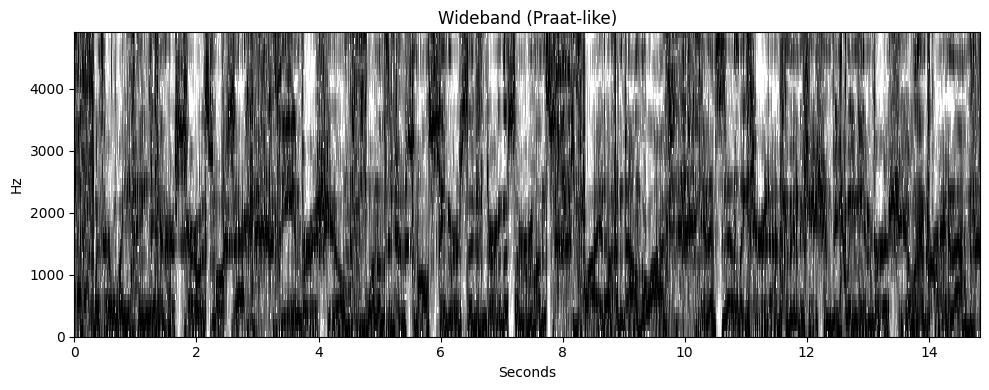

In [19]:
import librosa
import numpy as np
import matplotlib.pyplot as plt

def praat_like_wideband(
    x, sr,
    win_ms=5.0,
    hop_ms=1.0,
    n_fft=None,
    preemph=0.97,
    top_db=55.0,
    fmax=5000
):
    x = np.concatenate([[x[0]], x[1:] - preemph * x[:-1]])

    win_length = int(sr * win_ms / 1000)
    hop_length = int(sr * hop_ms / 1000)
    if n_fft is None:
        n_fft = win_length * 2

    S = np.abs(librosa.stft(
        x,
        n_fft=n_fft,
        hop_length=hop_length,
        win_length=win_length,
        window="hann",
        center=True
    ))**2

    ref = np.maximum(np.max(S, axis=0, keepdims=True), 1e-12)
    S_db = 10.0 * np.log10(S / ref)
    S_db = np.maximum(S_db, -top_db)

    freqs = librosa.fft_frequencies(sr=sr, n_fft=n_fft)
    keep = freqs <= fmax

    times = librosa.frames_to_time(
        np.arange(S_db.shape[1]),
        sr=sr,
        hop_length=hop_length
    )

    return S_db[keep], freqs[keep], times


def plot_spec(S_db, freqs, times, title=""):
    plt.figure(figsize=(10, 4))
    plt.imshow(
        S_db,
        origin="lower",
        aspect="auto",
        interpolation="none",
        extent=[times[0], times[-1], freqs[0], freqs[-1]],
        cmap="gray_r"
    )
    plt.xlabel("Seconds")
    plt.ylabel("Hz")
    plt.title(title)
    plt.tight_layout()
    plt.show()

x, sr = librosa.load(librosa.ex("libri1"), sr=None, mono=True)

S_db, freqs, times = praat_like_wideband(
    x, sr,
    win_ms=5.0,
    hop_ms=1.0,
    top_db=50.0,
    fmax=5000
)

plot_spec(S_db, freqs, times, title="Wideband (Praat-like)")
